Bank Churn Prediction

Objective:

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

Points Distribution:

The points distribution for this case is as follows:

1. Read the dataset
2. Drop the columns which are unique for all users like IDs (5 points)
3. Perform bivariate analysis and give your insights from the same (5 points) 
4. Distinguish the feature and target set and divide the data set into training and test sets (5 points)
5. Normalize the train and test data (10points)
6. Initialize & build the model. Identify the points of improvement and implement the same. (20)
7. Predict the results using 0.5 as a threshold (10points)
8. Print the Accuracy score and confusion matrix (5 points)


### Load the libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

### Read the dataset

In [3]:
df = pd.read_csv('bank.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### The RowNumber and CustomerId can be removed as they are not predictors. 
### Similarly Surname should also have no relatioship to the predicted variable Exited.
### Still we check that Surname has lots of different values, hence can be dropped. 

In [4]:
df['Surname'].nunique()

2932

In [5]:
df1 = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

### Lets check some basic statistics on the df1 dataframe.

In [6]:
df1.shape

(10000, 11)

In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [8]:
df1.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [9]:
df1[df1.duplicated()]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [10]:
df1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


### We can see that some columns have discrete values whereas others are continuous. 
### First check the correlation heatmap among the continuous variables. 

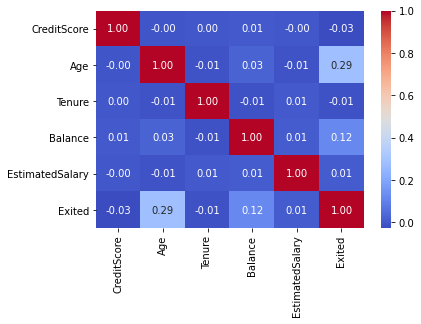

In [11]:
# Pairplot commented out to reduce the size of the .ipynb file and .html file.
#sns.pairplot(df1[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Exited']])
corr = df1[['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'Exited']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')

### There is no strong correlation observed among the continuous variables. 
### Below we check the correlation of each continuous variable predictor to the output variable, Exited.

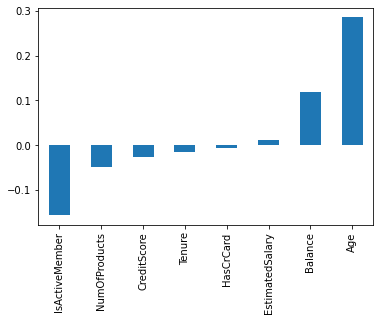

In [12]:
df1.corr()['Exited'].sort_values().drop('Exited').plot(kind='bar')

### We see that Age and Balance has somewhat positive influence on Exited. 

### Check for outliers in the continuous data columns

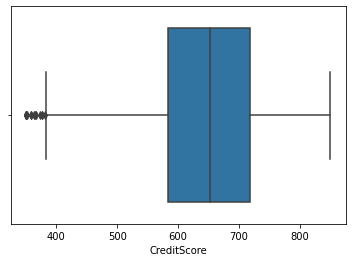

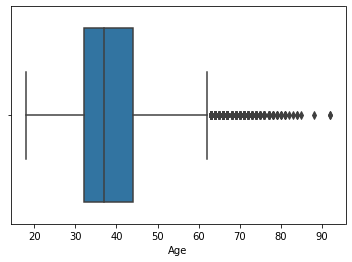

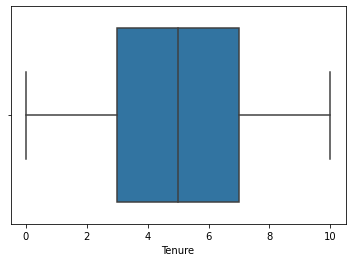

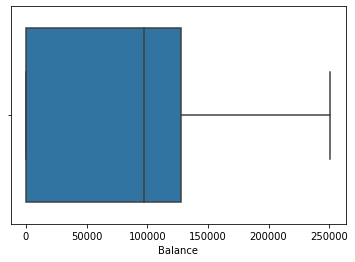

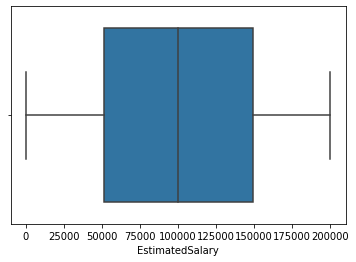

In [13]:
cont_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
for col in cont_cols:
    sns.boxplot(df1[col])
    plt.show()

### There are some outliers in Age and CreditScore
### We will use StandardScaler or RobustScaler when scaling the data

### Looking at the distributions of each variable with respect to the Exited=0 and 1.

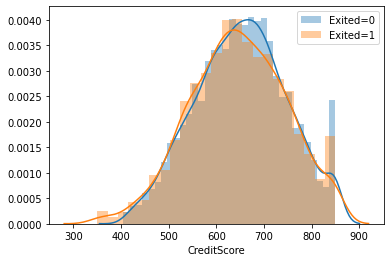

In [14]:
sns.distplot(df1[df1['Exited'] == 0]['CreditScore'], label='Exited=0')
sns.distplot(df1[df1['Exited'] == 1]['CreditScore'], label='Exited=1')
plt.legend()
plt.show()

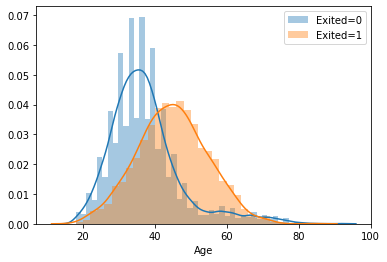

In [15]:
sns.distplot(df1[df1['Exited'] == 0]['Age'], label='Exited=0')
sns.distplot(df1[df1['Exited'] == 1]['Age'], label='Exited=1')
plt.legend()
plt.show()

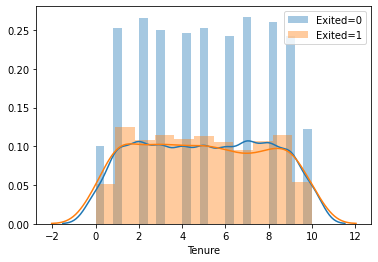

In [16]:
sns.distplot(df1[df1['Exited'] == 0]['Tenure'], label='Exited=0')
sns.distplot(df1[df1['Exited'] == 1]['Tenure'], label='Exited=1')
plt.legend()
plt.show()

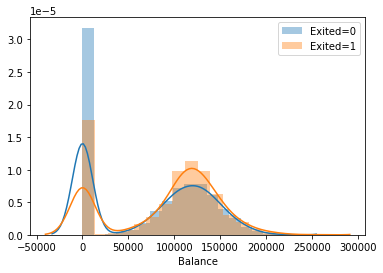

In [17]:
sns.distplot(df1[df1['Exited'] == 0]['Balance'], label='Exited=0')
sns.distplot(df1[df1['Exited'] == 1]['Balance'], label='Exited=1')
plt.legend()
plt.show()

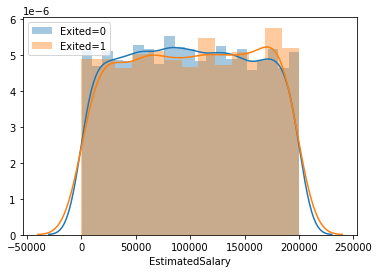

In [18]:
sns.distplot(df1[df1['Exited'] == 0]['EstimatedSalary'], label='Exited=0')
sns.distplot(df1[df1['Exited'] == 1]['EstimatedSalary'], label='Exited=1')
plt.legend()
plt.show()

### As we have observed from correlation, Age and Balance seem to segreate the Exited=0 and 1 classes to some extent.
### Now look at the counts of the output variable. As expected, there is an imbalance with Exited=1 about 1/4 of Exited=0.

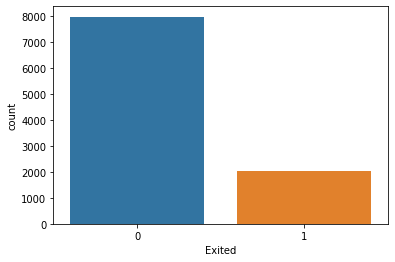

In [19]:
sns.countplot(df1['Exited'])

### This means we should focus on the Recall (reduce False Negatives) and not Accuracy. 

### Check the categorical columns and the numerical columns which has few values.

In [20]:
df1['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

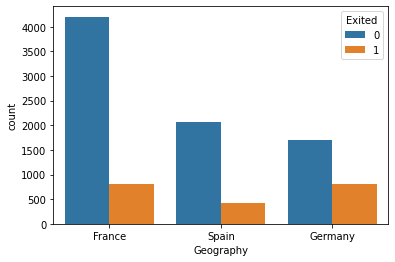

In [21]:
sns.countplot(df1['Geography'], hue='Exited', data=df1)

In [22]:
df1['Tenure'].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64

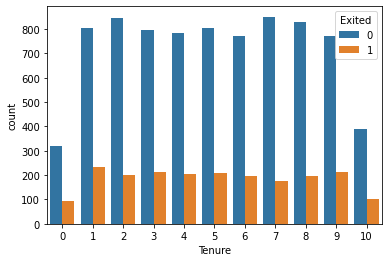

In [23]:
sns.countplot(df1['Tenure'], hue='Exited', data=df1)

In [24]:
df1['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

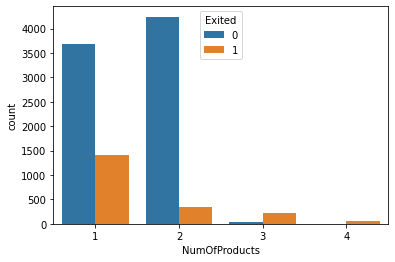

In [25]:
sns.countplot(df1['NumOfProducts'], hue='Exited', data=df1)

### Above shows that most of the Exits happened with NumOfProducts=1. 
### This is logical as less no. of accounts and relationships with the bank makes it easy for a customer to switch. 

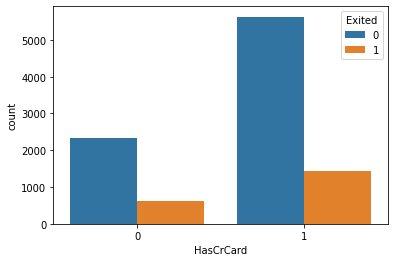

In [26]:
sns.countplot(df1['HasCrCard'], hue='Exited', data=df1)

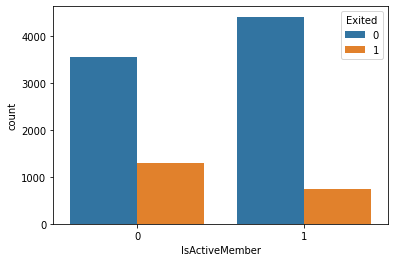

In [27]:
sns.countplot(df1['IsActiveMember'], hue='Exited', data=df1)

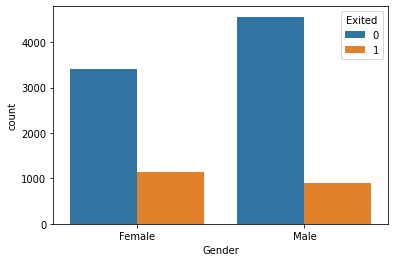

In [28]:
sns.countplot(df1['Gender'], hue='Exited', data=df1)

### There are no other strong indicators of churn in the above categorical columns.

In [29]:
df1.groupby('Exited').mean()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Exited,,,,,,,,
0,651.853196,37.408389,5.033279,72745.296779,1.544267,0.707146,0.554565,99738.391772
1,645.351497,44.837997,4.932744,91108.539337,1.475209,0.699067,0.360825,101465.677531


### Lets check if we want to make any numerical column categorical.

In [30]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


### We will leave HasCrCard and IsActiveMember as they anyway just have two values, where 1 implies higher order than 0. 
### Same for Tenure where order has a significance.
### Just convert the Geography and Gender to category.

In [31]:
#df1['HasCrCard'] = df1['HasCrCard'].astype('category')
#df1['IsActiveMember'] = df1['IsActiveMember'].astype('category')
df1['Geography'] = df1['Geography'].astype('category')
df1['Gender'] = df1['Gender'].astype('category')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null category
Gender             10000 non-null category
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: category(2), float64(2), int64(7)
memory usage: 723.0 KB


In [32]:
df2 = pd.get_dummies(df1, drop_first=True)
df2.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


### Get the features and target in X and y respectively.

In [33]:
X = df2.drop('Exited', axis=1)
y = df2['Exited']

### Load sklearn libraries

In [34]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix

### Train and test split the data

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7000, 11), (3000, 11), (7000,), (3000,))

### Fit the scaler on the training data and transform the train and test features.

In [36]:
scaler = RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[-1.04444444, -0.66666667,  0.66666667, ...,  0.        ,
         1.        , -1.        ],
       [ 0.54074074,  2.41666667, -0.16666667, ...,  0.        ,
         0.        ,  0.        ],
       [-0.31851852,  2.        , -0.66666667, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.47407407,  0.33333333,  0.5       , ...,  1.        ,
         0.        ,  0.        ],
       [-0.54814815, -0.41666667, -0.16666667, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00740741, -0.58333333, -0.5       , ...,  0.        ,
         1.        , -1.        ]])

### Model building and evaluation
### Functions to build, fit and evaluate a Model
### These can be called repeatedly by varying hyperparameters to tune the model topology, execution parameters and results

In [37]:
from numpy.random import seed
seed(101)

# Function to define the topology of a model
def build_model(topology, add_dropout=False):
    num_layers = len(topology)
    model = Sequential()
    for l in range(num_layers):
        num_neurons = topology[l]
        if (num_neurons > 1):
            model.add(Dense(num_neurons, activation='relu'))
            if (add_dropout == True):
                model.add(Dropout(0.2))
        else:
            model.add(Dense(num_neurons, activation='sigmoid'))
    return model

In [38]:
# Function to fit the training set on a model with reasonable defaults
# It also uses 20% of the training data for validation.
def fit_model(model, X, y, loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], 
                epochs=200, batch_size=100, callbacks=[], verbose=1):
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    history = model.fit(X, y, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=verbose)
    return history

In [39]:
# Function to plot the training/validation loss vs. epochs, 
# measure accuracy, recall, precision and
# print classification report and confusion matrix 
def evaluate_model(history, X_test, y_test, plot=True):
    if (plot == True):
        plt.title('Model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epochs')
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        plt.title('Model loss')
        plt.ylabel('loss')
        plt.xlabel('epochs')
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
    # Print the accuracy on test data
    loss, acc = model.evaluate(X_test, y_test)
    print("Accuracy on test data: {}".format(acc))

    # Print confusion matrix and classification report based on 0.5 threshold
    y_predict = model.predict(X_test_scaled)
    y_predict = list(map(lambda x: 1 if (x > 0.5) else 0, y_predict))
    acc = accuracy_score(y_test, y_predict)
    recall = recall_score(y_test, y_predict)
    f1 = f1_score(y_test, y_predict)
    print(classification_report(y_test, y_predict))
    print('\n')
    print('Accuracy score: {}'.format(acc))
    print('Recall score:   {}'.format(recall))
    print('F1 score:       {}'.format(f1))
    print('\n')
    cm=confusion_matrix(y_test, y_predict)
    cmdf = pd.DataFrame(cm, index=['Actual-0', 'Actual-1'], columns=['Predicted-0', 'Predicted-1'])
    #print(cmdf)
    sns.heatmap(cmdf, annot=True, fmt='.0f', cmap='coolwarm')
    return [acc, recall, f1, cm[1][0]]


In [40]:
# We will collect the results for various NN configurations in this.
results = dict()

### Define a model with 3 hidden (11, 10, 5 neurons) layers and 1 output layer

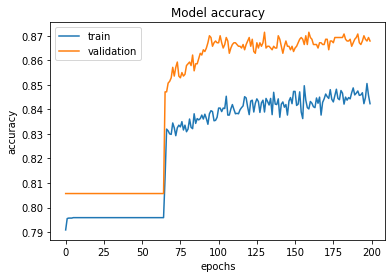

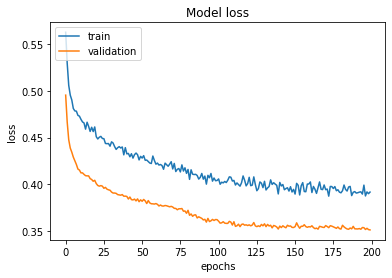

94/94 [==============================] - 0s 1ms/step - loss: 0.3455 - accuracy: 0.8633
Accuracy on test data: 0.8633333444595337
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2378
           1       0.75      0.51      0.61       622

    accuracy                           0.86      3000
   macro avg       0.82      0.73      0.76      3000
weighted avg       0.85      0.86      0.85      3000



Accuracy score: 0.8633333333333333
Recall score:   0.5080385852090032
F1 score:       0.6065259117082534




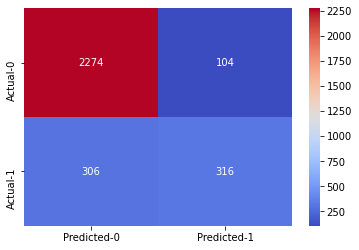

In [41]:
model = build_model([11, 10, 5, 1], True)
history = fit_model(model, X_train_scaled, y_train, verbose=0)
results['model_3_hidden'] = evaluate_model(history, X_test_scaled, y_test)

### We need to reduce the False Negatives (lower left cell)
### Since the loss curve was relatively flattened before 200 epochs, increasing epochs may not help.
### Let us try simplifying the network by reducing hidden layers.

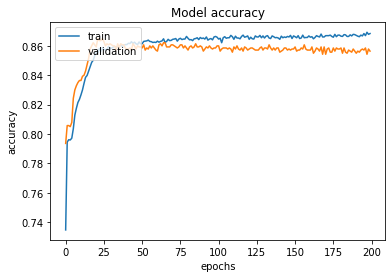

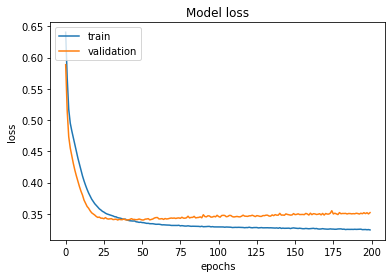

94/94 [==============================] - 0s 993us/step - loss: 0.3339 - accuracy: 0.8620
Accuracy on test data: 0.8619999885559082
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2378
           1       0.75      0.50      0.60       622

    accuracy                           0.86      3000
   macro avg       0.82      0.73      0.76      3000
weighted avg       0.85      0.86      0.85      3000



Accuracy score: 0.862
Recall score:   0.5016077170418006
F1 score:       0.6011560693641619




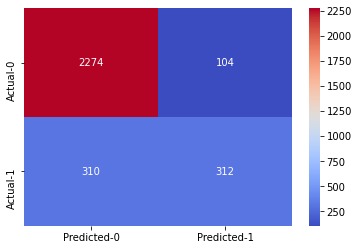

In [42]:
# Simplify the topology a bit
model = build_model([11, 5, 1], False)
history = fit_model(model, X_train_scaled, y_train, verbose=0)
results['model_2_hidden'] = evaluate_model(history, X_test_scaled, y_test)

### With the simplified model, the mis-classification of churns were similar. 
### The above curves show that beyond 60-80 epochs, the model starts overfitting.
### Below we will use a keras feature EarlyStopping to detect and stop before overfitting. 

Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping


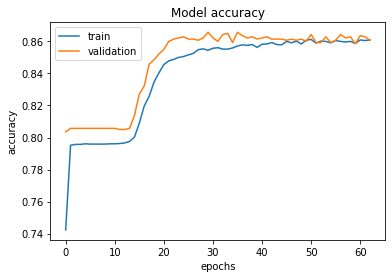

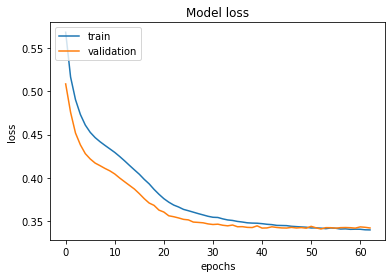

94/94 [==============================] - 0s 1ms/step - loss: 0.3320 - accuracy: 0.8657
Accuracy on test data: 0.8656666874885559
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2378
           1       0.77      0.50      0.61       622

    accuracy                           0.87      3000
   macro avg       0.82      0.73      0.76      3000
weighted avg       0.86      0.87      0.85      3000



Accuracy score: 0.8656666666666667
Recall score:   0.5048231511254019
F1 score:       0.609117361784675




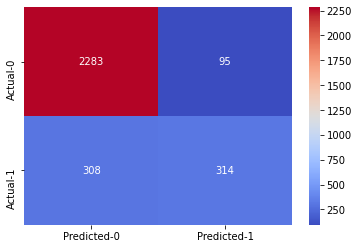

In [43]:
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
# Simplify the topology a bit
model = build_model([11, 5, 1], False)
history = fit_model(model, X_train_scaled, y_train, callbacks=[early], verbose=0)
results['model_2_hidden_earlystop'] = evaluate_model(history, X_test_scaled, y_test)

### This changed the results slightly, but not much. 
### We will making another attempt by tweaking the learning rate hyperparameter 
### and using a different optimizer SGD.
### We also increased the epochs to 500, as it was seen the val_loss still decreasing after 200. 
### The early stopping will stop it if it overfits earlier.

Restoring model weights from the end of the best epoch.
Epoch 00242: early stopping


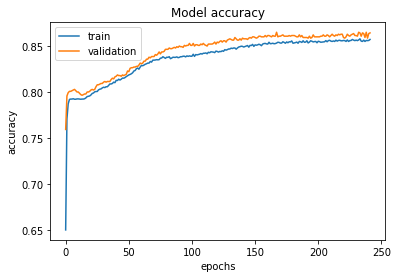

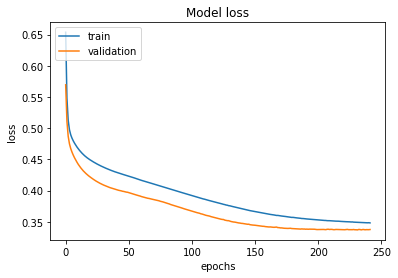

94/94 [==============================] - 0s 982us/step - loss: 0.3339 - accuracy: 0.8643
Accuracy on test data: 0.8643333315849304
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2378
           1       0.78      0.48      0.59       622

    accuracy                           0.86      3000
   macro avg       0.83      0.72      0.76      3000
weighted avg       0.86      0.86      0.85      3000



Accuracy score: 0.8643333333333333
Recall score:   0.477491961414791
F1 score:       0.5934065934065934




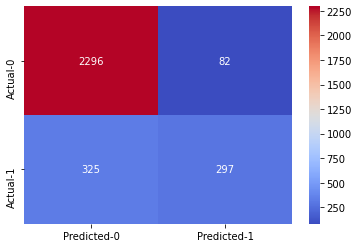

In [44]:
sgd = SGD(learning_rate=0.01, nesterov=False)
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
# Simplify the topology a bit
model = build_model([11, 5, 1], False)
history = fit_model(model, X_train_scaled, y_train, optimizer=sgd, callbacks=[early], epochs=500, verbose=0)
results['model_2_hidden_sgd_epochs_500'] = evaluate_model(history, X_test_scaled, y_test)

### Again we did not get any improvement.
### Let us try a wider and one deeper network, with Dropout. 
### This may capture any non-linearity that is missing so far.

Restoring model weights from the end of the best epoch.
Epoch 00449: early stopping


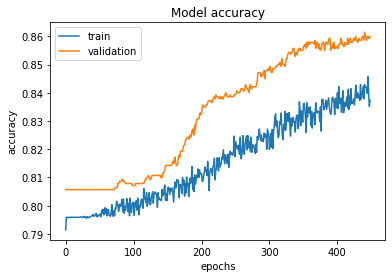

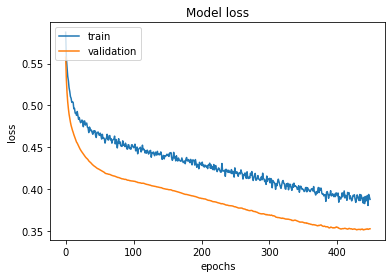

94/94 [==============================] - 0s 976us/step - loss: 0.3530 - accuracy: 0.8587
Accuracy on test data: 0.8586666584014893
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      2378
           1       0.84      0.39      0.54       622

    accuracy                           0.86      3000
   macro avg       0.85      0.69      0.73      3000
weighted avg       0.86      0.86      0.84      3000



Accuracy score: 0.8586666666666667
Recall score:   0.39228295819935693
F1 score:       0.5350877192982457




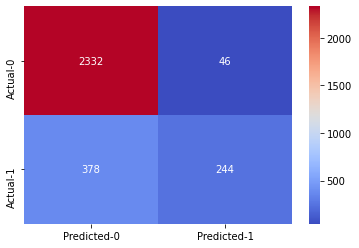

In [45]:
sgd = SGD(learning_rate=0.01, nesterov=False)
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
# Widen and deepen the topology a bit, also use Dropout=True to avoid overfitting
model = build_model([11, 22, 10, 1], True)
history = fit_model(model, X_train_scaled, y_train, optimizer=sgd, callbacks=[early], epochs=500, verbose=0)
results['model_22_wide_3_hidden'] = evaluate_model(history, X_test_scaled, y_test)

### Complex network topology does not help in this case. 
### The recall and F1-score keep varying around the same range for a simpler network. 
### We can keep tweaking the topology of the network and its hyperparameters. 
### At this point it seems the recall/f1-score are not changing much, so probably we are already hitting the optimal numbers of 0.5-0.6
### for this dataset. 

### Try a really simple topology as last resort.

Restoring model weights from the end of the best epoch.
Epoch 00134: early stopping


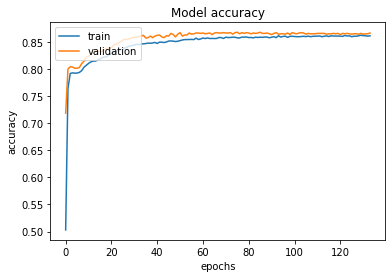

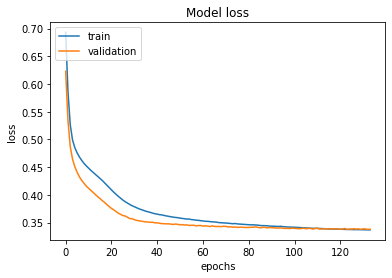

94/94 [==============================] - 0s 975us/step - loss: 0.3279 - accuracy: 0.8650
Accuracy on test data: 0.8650000095367432
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2378
           1       0.78      0.49      0.60       622

    accuracy                           0.86      3000
   macro avg       0.83      0.73      0.76      3000
weighted avg       0.86      0.86      0.85      3000



Accuracy score: 0.865
Recall score:   0.4903536977491961
F1 score:       0.6009852216748768




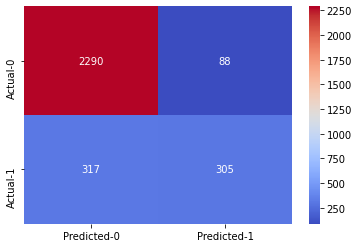

In [46]:
early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
# Simplify the topology a bit
model = build_model([11, 1], False)
history = fit_model(model, X_train_scaled, y_train, callbacks=[early], verbose=0)
results['model_1_hidden_earlystop'] = evaluate_model(history, X_test_scaled, y_test)

### Let us do a final check with RandomForest. 

In [47]:
from sklearn.ensemble import RandomForestClassifier

Accuracy on test data: 0.8643333333333333
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2378
           1       0.78      0.48      0.60       622

    accuracy                           0.86      3000
   macro avg       0.83      0.72      0.76      3000
weighted avg       0.86      0.86      0.85      3000



Accuracy score: 0.8643333333333333
Recall score:   0.48231511254019294
F1 score:       0.5958291956305859




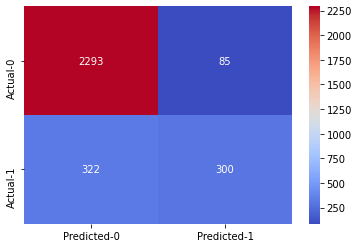

In [48]:
rf = RandomForestClassifier(random_state=101)
rf.fit(X_train_scaled, y_train)
predicts = rf.predict(X_test_scaled)
print("Accuracy on test data: {}".format(accuracy_score(y_test, predicts)))
print(classification_report(y_test, predicts))
acc = accuracy_score(y_test, predicts)
recall = recall_score(y_test, predicts)
f1 = f1_score(y_test, predicts)
print('\n')
print('Accuracy score: {}'.format(acc))
print('Recall score:   {}'.format(recall))
print('F1 score:       {}'.format(f1))
print('\n')
cmdf = pd.DataFrame(confusion_matrix(y_test, predicts), index=['Actual-0', 'Actual-1'], columns=['Predicted-0', 'Predicted-1'])
sns.heatmap(cmdf, annot=True, fmt='.0f', cmap='coolwarm')
results['random_forest'] = [acc, recall, f1, cmdf.iloc[1,0]]

### We got very similar numbers using Random Forest. 
### Below is presented the results for different trials.


In [49]:
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy', 'Recall', 'F1-score', 'False Negatives'])
results_df

,Accuracy,Recall,F1-score,False Negatives
model_3_hidden,0.863333,0.508039,0.606526,306
model_2_hidden,0.862000,0.501608,0.601156,310
model_2_hidden_earlystop,0.865667,0.504823,0.609117,308
model_2_hidden_sgd_epochs_500,0.864333,0.477492,0.593407,325
model_22_wide_3_hidden,0.858667,0.392283,0.535088,378
model_1_hidden_earlystop,0.865000,0.490354,0.600985,317
random_forest,0.864333,0.482315,0.595829,322


### In this dataset, the scores vary from 0.47 to 0.50 for Recall which are mostly similar.
### The only thing that stands out is complex model (model_22_wide_3_hidden) did not perform well in this set due to overfitting.
### Neural network models are not fully repeatable, so the scores will vary a little but close to Random Forest.

### Plot feature importances from rf to check our earlier observation from EDA.

<BarContainer object of 11 artists>

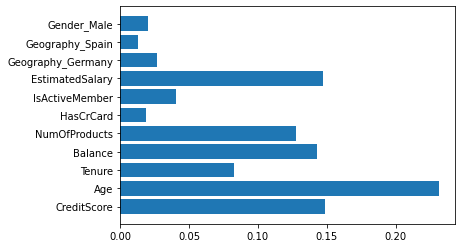

In [50]:
feature_importances = rf.feature_importances_
plt.barh(df2.drop('Exited', axis=1).columns, feature_importances)

### Conclusion:
### The predictions may use a lower threshold than 0.5 to better capture the ~300 misclassifications.
### Simpler network topology gives optimal results on this dataset. 
### Complex network will overfit and perform worse on a test set.
### Business results:
#### Age, CreditScore, Balance, NumOfProducts and EstimatedSalary seem to have most influence on the customer churn. 
#### Geography, IsActiveMember or HasCrCard are not so important predictors.
#### Tenure has some impact but less than the top 5. 


### 